In [18]:
import os
import torch
import nltk 
from datasets import load_dataset
from transformers import T5Tokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import matplotlib.pyplot as plt 

nltk.download('punkt_tab', quiet=True) 
nltk.download('punkt', quiet=True)

True

# Загрузка и подготовка датасета

In [ ]:
TRAIN_FILE = 'final_data/train.csv'
VALID_FILE = 'final_data/validation.csv'

MODEL_NAME = "ai-forever/ruT5-base"
OUTPUT_DIR = "./results_rut5_sum"

# Ограничения на длину входного и выходного текста
MAX_SOURCE_LENGTH = 512
MAX_TARGET_LENGTH = 64 

# Гиперпараметры 
BATCH_SIZE_PER_DEVICE = 2
GRADIENT_ACCUMULATION_STEPS = 8
LEARNING_RATE = 0.00001
NUM_TRAIN_EPOCHS = 20
WEIGHT_DECAY = 0.01

In [20]:
data_files = {}
data_files["train"] = TRAIN_FILE
data_files["validation"] = VALID_FILE
raw_datasets = load_dataset("csv", data_files=data_files)

print("Пример данных из train")
print(f'Новость: {raw_datasets["train"][0]["text"]}')
print(f'Суммари: {raw_datasets["train"][0]["summary"]}')

Пример данных из train
Новость: В Китае от птичьего гриппа умерли по меньшей мере 26 человек. Несмотря на то, что большинство из 127 случаев заболевания были зарегистрированы в восточных провинциях, последний погибший родом из центральной части страны. 1 мая Всемирная организация здравоохранения предупредила, что вирус H7N9 в Китае представляет серьезную опасность для здоровья людей. До сих пор нет доказательств того, что вирус может передаваться от человека к человеку, однако ученые выразили обеспокоенность темпом распространения и серьезностью заболевания.
Суммари: Государственные СМИ Китая сообщают, что по меньшей мере 26 человек уже погибли от нового штамма вируса птичьего гриппа.


In [ ]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

# Токенизация входного текста и резюме
def preprocess_function(examples):
    texts = [str(doc) if doc is not None else "" for doc in examples["text"]]
    summaries = [str(doc) if doc is not None else "" for doc in examples["summary"]]

    model_inputs = tokenizer(texts, max_length=MAX_SOURCE_LENGTH, truncation=True)
    labels = tokenizer(text_target=summaries, max_length=MAX_TARGET_LENGTH, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


columns_to_remove = raw_datasets["train"].column_names
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True, remove_columns=columns_to_remove)
print("Пример токенизированных данных:", tokenized_datasets["train"][0])

Пример токенизированных данных: {'input_ids': [32, 7805, 26, 454, 469, 23572, 16622, 7, 20646, 17, 9975, 971, 1831, 229, 4, 2847, 9, 62, 3, 16, 2204, 29, 537, 701, 2926, 2749, 150, 5445, 19, 6, 23189, 29594, 56, 3, 1593, 2633, 1455, 851, 34, 29, 11215, 561, 762, 4, 206, 1259, 243, 1357, 108, 3931, 8633, 9155, 7, 3, 16, 4258, 1285, 701, 1945, 1037, 6, 7805, 1940, 27948, 5486, 44, 2962, 297, 4, 422, 1440, 485, 190, 11146, 147, 3, 16, 4258, 126, 17983, 57, 26, 320, 24, 2376, 3, 771, 7206, 7887, 15, 18771, 370, 7051, 34, 11778, 5, 2684, 1049, 2749, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [9320, 1109, 3129, 7836, 16779, 3, 16, 17, 9975, 971, 1831, 229, 94, 7494, 26, 1205, 2641, 158, 532, 4258, 7,

# Настройка коллатора, модели и аргументов для обучения 

In [22]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=tokenizer.pad_token_id,
    pad_to_multiple_of=8
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Аргументы для обучения модели
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",      
    logging_steps=100,        
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE_PER_DEVICE,
    per_device_eval_batch_size=BATCH_SIZE_PER_DEVICE, 
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    save_strategy="epoch",       
    predict_with_generate=False, 
    generation_max_length=MAX_TARGET_LENGTH,
    generation_num_beams=4,
    fp16=True,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets.get("validation"), 
    tokenizer=tokenizer,
    data_collator=data_collator
)

C:\Users\Gapba\AppData\Local\Temp\ipykernel_23948\1001441181.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


# Дообучение модели

In [24]:
train_result = trainer.train()
trainer.save_model()

Epoch,Training Loss,Validation Loss
0,1.901100,1.478388
1,1.785600,1.438107
2,1.716500,1.420358
3,1.677800,1.406814
4,1.667900,1.397566
5,1.609100,1.389332
6,1.603300,1.386873
7,1.548000,1.379907
8,1.564100,1.377384
9,1.503700,1.374929


In [27]:
log_history = trainer.state.log_history

training_losses = []
train_steps = []
eval_losses = []
eval_epochs = [] 

for log_entry in log_history:
    if 'loss' in log_entry and 'eval_loss' not in log_entry and 'step' in log_entry:
        training_losses.append(log_entry['loss'])
        train_steps.append(log_entry['step'])
    if 'eval_loss' in log_entry and 'epoch' in log_entry:
        eval_losses.append(log_entry['eval_loss'])
        eval_epochs.append(round(log_entry['epoch'], 2))

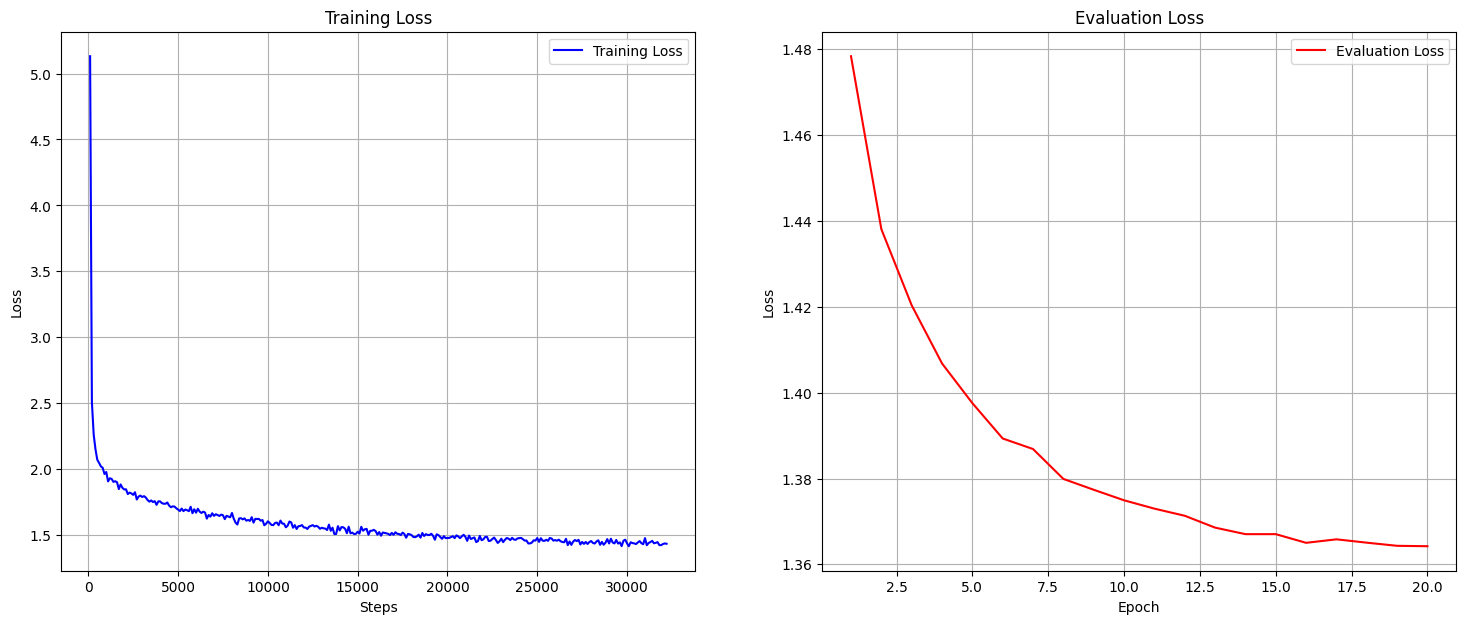

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

axes[0].plot(train_steps, training_losses, label='Training Loss', color='blue')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(eval_epochs, eval_losses, label='Evaluation Loss', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Evaluation Loss')
axes[1].legend()
axes[1].grid(True)